Load dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import optuna as optuna
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import datetime
import pytz
import pandas as pd
from google.oauth2 import service_account
import pandas as pd
import pandas_gbq as gbq 
from pandas_gbq import to_gbq, read_gbq
import matplotlib.pyplot as plt


c:\Documents\Capstone\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
credentials_path = '../token.json'

# Authenticate with your credentials
credentials = service_account.Credentials.from_service_account_file(
    credentials_path, scopes=['https://www.googleapis.com/auth/bigquery'])

# Set the credentials for pandas_gbq
gbq.context.credentials = credentials

In [3]:
data = read_gbq(f"""

SELECT *
FROM capstone-402105.capstone.cri_compustat_yfinance_data

""",project_id='capstone-402105', dialect='standard')

Downloading: 100%|██████████|


In [4]:
# data = pd.read_pickle('cri_compustat_yfinance.pkl')

In [5]:
data.shape

(579815, 61)

In [6]:
data.isna().sum().sort_values(ascending=False)

CompNo                 0
tic                    0
quick_ratio            0
cash_ratio             0
net_working_capital    0
                      ..
Default_12             0
Default_24             0
Default_36             0
Default_60             0
rsi                    0
Length: 61, dtype: int64

In [7]:
data.columns

Index(['CompNo', 'year', 'month', 'StkIndx', 'STInt', 'dtdlevel', 'dtdtrend',
       'liqnonfinlevel', 'liqnonfintrend', 'ni2talevel', 'ni2tatrend',
       'sizelevel', 'sizetrend', 'm2b', 'sigma', 'liqfinlevel', 'lqfintrend',
       'DTDmedianFin', 'DTDmedianNonFin', 'dummy297fin', 'StartDate',
       'EventDate', 'Default_1', 'Default_3', 'Default_6', 'Default_12',
       'Default_24', 'Default_36', 'Default_60', 'Duration', 'gvkey', 'tic',
       'current_ratio', 'quick_ratio', 'cash_ratio', 'net_working_capital',
       'debt_ratio', 'debt_to_equity_ratio', 'equity_ratio',
       'cashflow_to_debt_ratio', 'net_profit_margin', 'return_on_assets',
       'asset_turnover', 'inventory_turnover', 'days_in_inventory',
       'receivables_turnover', 'day_sales_outstanding',
       'working_capital_turnover', 'price_to_earnings',
       'dividend_payout_ratio', 'retention_ratio', 'gross_margin_ratio',
       'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 

top features

In [8]:
#load compna to get sic
compna = read_gbq(f"""

SELECT *
FROM capstone-402105.raw_data.sic_map

""",project_id='capstone-402105', dialect='standard')

Downloading: 100%|██████████|


In [9]:
data.columns

Index(['CompNo', 'year', 'month', 'StkIndx', 'STInt', 'dtdlevel', 'dtdtrend',
       'liqnonfinlevel', 'liqnonfintrend', 'ni2talevel', 'ni2tatrend',
       'sizelevel', 'sizetrend', 'm2b', 'sigma', 'liqfinlevel', 'lqfintrend',
       'DTDmedianFin', 'DTDmedianNonFin', 'dummy297fin', 'StartDate',
       'EventDate', 'Default_1', 'Default_3', 'Default_6', 'Default_12',
       'Default_24', 'Default_36', 'Default_60', 'Duration', 'gvkey', 'tic',
       'current_ratio', 'quick_ratio', 'cash_ratio', 'net_working_capital',
       'debt_ratio', 'debt_to_equity_ratio', 'equity_ratio',
       'cashflow_to_debt_ratio', 'net_profit_margin', 'return_on_assets',
       'asset_turnover', 'inventory_turnover', 'days_in_inventory',
       'receivables_turnover', 'day_sales_outstanding',
       'working_capital_turnover', 'price_to_earnings',
       'dividend_payout_ratio', 'retention_ratio', 'gross_margin_ratio',
       'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 

In [10]:
#create tic sic mapping
sic_map = compna[['tic', 'sic']]
sic_map= sic_map.drop_duplicates(subset=['tic'])

In [11]:
sic_map

,tic,sic
0,TT.2,3585
1,CUO,3585
2,DOV,3585
3,EASI.1,3585
4,FJCC,3585
...,...,...
30207,CNSF.1,6399
30208,TRUP,6399
30209,BNRE,6399
30210,PTHLF,6399


In [12]:
#map sic to data
data['sic'] = data['tic'].map(sic_map.set_index('tic')['sic'])
data

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio,Rolling_Sortino,macd,macd_h,macd_s,rsi,sic
0,27000,2018.0,5,0.121681,-0.004016,4.610432,-0.448221,-0.240527,-0.106833,0.007001,...,-71.233624,-66.102620,-0.532871,6.416667,-0.348730,-2.076896,-3.270315,1.193419,37.890034,4512
1,27088,2018.0,5,0.121681,-0.004016,5.805131,-0.252708,-0.046088,-0.005450,0.012289,...,-19.995316,-16.997218,-0.422721,14.308042,0.016073,-8.291237,-1.996518,-6.294719,47.519533,5531
2,27091,2018.0,5,0.121681,-0.004016,6.852873,-0.360996,1.041967,-0.029233,0.001064,...,-80.813431,-79.578732,-2.436108,7.957921,0.195634,-0.383585,-0.004297,-0.379289,46.398949,5065
3,27097,2018.0,5,0.121681,-0.004016,10.034662,-2.075873,0.065157,-0.001900,0.001923,...,-64.667864,-58.204668,-0.241162,5.972603,-0.070259,1.074468,-0.410459,1.484927,49.390527,3411
4,27117,2018.0,5,0.121681,-0.004016,9.269236,-6.134049,1.122227,-0.077907,0.008095,...,-61.798433,-60.044946,-0.493468,9.330209,0.225391,5.793433,0.533080,5.260353,67.624326,5080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579810,36938,2001.0,5,-0.115993,0.002831,4.419246,0.741598,0.000000,0.000000,0.003910,...,-6.609042,-2.505087,-0.015174,1.848453,0.356773,1.161392,0.083712,1.077680,71.190612,6798
579811,37586,2001.0,5,-0.115993,0.002831,7.907749,0.616155,0.000000,0.000000,0.005111,...,34.899109,-2.505087,-0.015174,1.848453,0.856301,0.654054,0.224513,0.429541,89.033611,6798
579812,38034,2001.0,5,-0.115993,0.002831,0.266577,0.650724,0.000000,0.000000,-0.000382,...,-70.055640,-52.984320,-0.923333,0.000000,0.074651,-8.761411,0.274134,-9.035545,38.899821,6035
579813,40987,2001.0,5,-0.115993,0.002831,2.773438,1.230261,0.000000,0.000000,-0.002265,...,5.644276,55.770168,0.005406,1.988625,-0.007637,-5.035284,-0.337237,-4.698046,32.699692,6798


In [13]:
#top features retrieved from the feature importance at the lightgbm_yfinace.ipynb
top_features = ['net_working_capital', 'DTDmedianNonFin', 'debt_ratio', 'm2b', 'working_capital_turnover']


In [14]:
#create new columns according to industry average for each grouby sic code
for col in top_features:
    new_col_name = col + '_industry_avg'
    data[new_col_name] = data.groupby('sic')[col].transform('mean')

In [15]:
data

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,macd,macd_h,macd_s,rsi,sic,net_working_capital_industry_avg,DTDmedianNonFin_industry_avg,debt_ratio_industry_avg,m2b_industry_avg,working_capital_turnover_industry_avg
0,27000,2018.0,5,0.121681,-0.004016,4.610432,-0.448221,-0.240527,-0.106833,0.007001,...,-2.076896,-3.270315,1.193419,37.890034,4512,-167.098598,3.746988,0.363687,1.685645,-0.369035
1,27088,2018.0,5,0.121681,-0.004016,5.805131,-0.252708,-0.046088,-0.005450,0.012289,...,-8.291237,-1.996518,-6.294719,47.519533,5531,798.512401,3.730654,0.304662,1.809651,5.548427
2,27091,2018.0,5,0.121681,-0.004016,6.852873,-0.360996,1.041967,-0.029233,0.001064,...,-0.383585,-0.004297,-0.379289,46.398949,5065,1300.463659,3.840713,0.188242,0.704421,1.199366
3,27097,2018.0,5,0.121681,-0.004016,10.034662,-2.075873,0.065157,-0.001900,0.001923,...,1.074468,-0.410459,1.484927,49.390527,3411,377.164326,3.824132,0.507239,1.172561,3.173160
4,27117,2018.0,5,0.121681,-0.004016,9.269236,-6.134049,1.122227,-0.077907,0.008095,...,5.793433,0.533080,5.260353,67.624326,5080,291.660445,3.740802,0.231876,1.201491,1.378916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579810,36938,2001.0,5,-0.115993,0.002831,4.419246,0.741598,0.000000,0.000000,0.003910,...,1.161392,0.083712,1.077680,71.190612,6798,-32.488959,0.017193,0.561950,0.996649,-0.108899
579811,37586,2001.0,5,-0.115993,0.002831,7.907749,0.616155,0.000000,0.000000,0.005111,...,0.654054,0.224513,0.429541,89.033611,6798,-32.488959,0.017193,0.561950,0.996649,-0.108899
579812,38034,2001.0,5,-0.115993,0.002831,0.266577,0.650724,0.000000,0.000000,-0.000382,...,-8.761411,0.274134,-9.035545,38.899821,6035,21.464229,0.000000,0.188420,0.805169,-0.072941
579813,40987,2001.0,5,-0.115993,0.002831,2.773438,1.230261,0.000000,0.000000,-0.002265,...,-5.035284,-0.337237,-4.698046,32.699692,6798,-32.488959,0.017193,0.561950,0.996649,-0.108899


In [16]:
#compute relative ratio
data['relative_net_working_capital'] = ((data['net_working_capital'] - data['net_working_capital_industry_avg']) / data['net_working_capital_industry_avg']) * 100
data['relative_debt_ratio'] = ((data['debt_ratio'] - data['debt_ratio_industry_avg']) / data['debt_ratio_industry_avg']) * 100
data['relative_DTDmedianNonFin'] = ((data['DTDmedianNonFin'] - data['DTDmedianNonFin_industry_avg']) / data['DTDmedianNonFin_industry_avg']) * 100
data['relative_m2b'] = ((data['m2b'] - data['m2b_industry_avg']) / data['m2b_industry_avg']) * 100
data['relative_working_capital_turnover'] = ((data['working_capital_turnover'] - data['working_capital_turnover_industry_avg']) / data['working_capital_turnover_industry_avg']) * 100

In [18]:
data.isna().sum().sort_values(ascending= False)

relative_DTDmedianNonFin             33400
relative_debt_ratio                    109
CompNo                                   0
receivables_turnover                     0
gross_margin_ratio                       0
                                     ...  
Default_3                                0
Default_1                                0
EventDate                                0
StartDate                                0
relative_working_capital_turnover        0
Length: 72, dtype: int64

In [19]:
data[data.isna().any(axis=1)]

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,net_working_capital_industry_avg,DTDmedianNonFin_industry_avg,debt_ratio_industry_avg,m2b_industry_avg,working_capital_turnover_industry_avg,relative_net_working_capital,relative_debt_ratio,relative_DTDmedianNonFin,relative_m2b,relative_working_capital_turnover
486142,48912,2003.0,11,0.433714,-0.001383,1.772456,0.504323,0.0,0.0,0.001492,...,17.967811,0.0,0.055538,0.800862,2.632996,-71.888619,-39.484644,NaN,-13.728463,-47.892216
486171,54249,2013.0,4,-0.006894,-0.007239,3.035853,1.202214,0.0,0.0,0.000319,...,1.526225,0.0,0.030048,0.767707,39.911031,-104.914084,-29.442145,NaN,16.399594,-100.000000
486175,48222,2013.0,4,-0.006894,-0.007239,7.494122,-1.014768,0.0,0.0,0.008355,...,-200.365814,0.0,0.480757,0.752872,-0.067054,-13.547128,-20.900990,NaN,4.563473,550.475748
486179,49092,2013.0,4,-0.006894,-0.007239,4.769361,1.215640,0.0,0.0,0.000646,...,1.526225,0.0,0.030048,0.767707,39.911031,-104.914084,-16.029836,NaN,19.972967,-100.000000
486181,49763,2013.0,4,-0.006894,-0.007239,4.388050,1.032052,0.0,0.0,0.000286,...,1.526225,0.0,0.030048,0.767707,39.911031,-104.914084,36.823481,NaN,10.387573,-100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579788,39005,2001.0,5,-0.115993,0.002831,1.550341,0.789774,0.0,0.0,0.000472,...,17.967811,0.0,0.055538,0.800862,2.632996,-103.255822,-57.125382,NaN,10.602240,7732.014129
579796,27942,2001.0,5,-0.115993,0.002831,1.781706,0.611141,0.0,0.0,-0.000203,...,17.967811,0.0,0.055538,0.800862,2.632996,-103.255822,-54.480973,NaN,4.449325,7732.014129
579804,31678,2001.0,5,-0.115993,0.002831,2.445050,-0.278974,0.0,0.0,0.000834,...,17.967811,0.0,0.055538,0.800862,2.632996,-103.255822,-54.480973,NaN,8.037079,7732.014129
579806,32061,2001.0,5,-0.115993,0.002831,2.197331,0.082337,0.0,0.0,0.001461,...,21.464229,0.0,0.188420,0.805169,-0.072941,-6.006409,-54.994125,NaN,27.849464,9311.134909


In [20]:
data.dropna(inplace=True)
df = data

In [21]:
#drop the columns to avoid highly correlated features
for col in top_features:
    new_col_name = col + '_industry_avg'
    df.drop(columns = [new_col_name], inplace=True)

In [22]:
#sort accoriding to dat and split into train, validation and test set
df.sort_values(by='EventDate', inplace=True)
date2022 = datetime.datetime(2022, 1, 1).replace(tzinfo=pytz.UTC)
date2020 = datetime.datetime(2020,1,1).replace(tzinfo=pytz.UTC)
train_df = df[df["EventDate"] < date2020]
validation_df = df[(df["EventDate"] >= date2020) & (df["EventDate"] < date2022)]
test_df = df[df["EventDate"] >= date2022]

In [23]:
#drop unecessary columns
train_df = train_df.drop(columns=['CompNo','year','month','StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey'])
validation_df = validation_df.drop(columns=['CompNo','year','month','StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey'])
test_df = test_df.drop(columns=['CompNo','year','month','StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey'])

In [24]:
#futher split into x and y for train, validation and test set
x_train = train_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_train = train_df['Default_12']
x_validation = validation_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_validation = validation_df['Default_12']
x_test = test_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_test = test_df["Default_12"]

In [25]:
x_train.columns

Index(['StkIndx', 'STInt', 'dtdlevel', 'dtdtrend', 'liqnonfinlevel',
       'liqnonfintrend', 'ni2talevel', 'ni2tatrend', 'sizelevel', 'sizetrend',
       'm2b', 'sigma', 'liqfinlevel', 'lqfintrend', 'DTDmedianFin',
       'DTDmedianNonFin', 'current_ratio', 'quick_ratio', 'cash_ratio',
       'net_working_capital', 'debt_ratio', 'debt_to_equity_ratio',
       'equity_ratio', 'cashflow_to_debt_ratio', 'net_profit_margin',
       'return_on_assets', 'asset_turnover', 'inventory_turnover',
       'days_in_inventory', 'receivables_turnover', 'day_sales_outstanding',
       'working_capital_turnover', 'price_to_earnings',
       'dividend_payout_ratio', 'retention_ratio', 'gross_margin_ratio',
       'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 'interest_coverage_ratio',
       'Rolling_Sortino', 'macd', 'macd_h', 'macd_s', 'rsi', 'sic',
       'relative_net_working_capital', 'relative_debt_ratio',
       'relative_DTDmedianNonFin', 'relative_m2b',
    

In [26]:
# WARNING: 2 changes to change evaluation metric
optimisation_metric = "auc" #"accuracy" "recall" "precision" "f1" "auc"
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'binary',
        'metric': 'auc', #"accuracy" "recall" "precision" "f1" "auc"
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        # 'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 10.0, log=True),
        'scale_pos_weight': 100,
        'max_depth': trial.suggest_int('max_depth', 2, 256),
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 500),
    }
    
    # full data
    gbm = lgb.train(param, lgb.Dataset(x_train, y_train))
    
    preds = gbm.predict(x_validation)
    y_pred_binary = np.round(preds)
    
    auc = roc_auc_score(y_validation, preds)
    accuracy = accuracy_score(y_validation, y_pred_binary)
    recall = recall_score(y_validation, y_pred_binary)
    precision = precision_score(y_validation, y_pred_binary)
    f1 = f1_score(y_validation, y_pred_binary)
    
    #choose the metric you want to optimized
    if optimisation_metric == 'recall': 
        return recall
    elif optimisation_metric == 'precision': 
        return precision
    elif optimisation_metric == 'f1':
        return f1
    elif optimisation_metric == 'auc':
        return auc
    elif optimisation_metric == 'accuracy': 
        return accuracy
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2023-11-10 22:12:16,755] A new study created in memory with name: no-name-01438105-ccc1-4ff2-8c90-535e1eeb9b60
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:12:54,744] Trial 0 finished with value: 0.8903074275881846 and parameters: {'num_leaves': 254, 'lambda_l1': 2.4838813376851246e-05, 'lambda_l2': 5.5406839373079856e-05, 'feature_fraction': 0.9313952745465742, 'min_child_samples': 33, 'learning_rate': 0.0016250430771710222, 'max_depth': 89, 'num_boost_round': 423}. Best is trial 0 with value: 0.8903074275881846.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:13:22,766] Trial 1 finished with value: 0.8807883248892714 and parameters: {'num_leaves': 180, 'lambda_l1': 1.536525937545189e-05, 'lambda_l2': 1.5860320482307258e-05, 'feature_fraction': 0.8595205376081659, 'min_child_samples': 36, 'learning_rate': 3.1496847932353446e-06, 'max_depth': 254, 'num_boost_round': 468}. Best is trial 0 with value: 0.8903074275881846.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:13:56,784] Trial 2 finished with value: 0.8371514514227448 and parameters: {'num_leaves': 239, 'lambda_l1': 0.36038298875256164, 'lambda_l2': 0.010975198090450403, 'feature_fraction': 0.9558917900528892, 'min_child_samples': 42, 'learning_rate': 2.9353873740980705e-08, 'max_depth': 107, 'num_boost_round': 499}. Best is trial 0 with value: 0.8903074275881846.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:14:05,292] Trial 3 finished with value: 0.8925319440461397 and parameters: {'num_leaves': 76, 'lambda_l1': 0.5790794088661202, 'lambda_l2': 9.427262265716406, 'feature_fraction': 0.6922359876430247, 'min_child_samples': 23, 'learning_rate': 8.718294363687792e-08, 'max_depth': 77, 'num_boost_round': 197}. Best is trial 3 with value: 0.8925319440461397.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:14:17,865] Trial 4 finished with value: 0.8747108944332919 and parameters: {'num_leaves': 52, 'lambda_l1': 8.160815586295485e-07, 'lambda_l2': 3.0075941651698383e-08, 'feature_fraction': 0.915014852475547, 'min_child_samples': 12, 'learning_rate': 0.00046477098005865195, 'max_depth': 30, 'num_boost_round': 246}. Best is trial 3 with value: 0.8925319440461397.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:14:39,565] Trial 5 finished with value: 0.8607946340375363 and parameters: {'num_leaves': 196, 'lambda_l1': 0.02788017023589712, 'lambda_l2': 0.00427986243000631, 'feature_fraction': 0.9253191184107266, 'min_child_samples': 8, 'learning_rate': 8.15191364406905e-05, 'max_depth': 12, 'num_boost_round': 375}. Best is trial 3 with value: 0.8925319440461397.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:14:48,988] Trial 6 finished with value: 0.9201598317560463 and parameters: {'num_leaves': 225, 'lambda_l1': 0.3350365914123577, 'lambda_l2': 6.811061608441406e-05, 'feature_fraction': 0.8283187813951569, 'min_child_samples': 37, 'learning_rate': 1.9602973675011754e-07, 'max_depth': 5, 'num_boost_round': 317}. Best is trial 6 with value: 0.9201598317560463.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2023-11-10 22:14:56,519] Trial 7 finished with value: 0.535049230475098 and parameters: {'num_leaves': 150, 'lambda_l1': 0.07780901262456598, 'lambda_l2': 0.00031902216784199196, 'feature_fraction': 0.4017386118929748, 'min_child_samples': 19, 'learning_rate': 2.909022690693588, 'max_depth': 66, 'num_boost_round': 484}. Best is trial 6 with value: 0.9201598317560463.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:15:10,427] Trial 8 finished with value: 0.8974435841060447 and parameters: {'num_leaves': 36, 'lambda_l1': 0.0014879652020311507, 'lambda_l2': 3.078411441622449, 'feature_fraction': 0.7345424394754767, 'min_child_samples': 31, 'learning_rate': 0.001083737756702673, 'max_depth': 45, 'num_boost_round': 388}. Best is trial 6 with value: 0.9201598317560463.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


[I 2023-11-10 22:15:28,361] Trial 9 finished with value: 0.8887477933913265 and parameters: {'num_leaves': 112, 'lambda_l1': 5.2751258771637055e-06, 'lambda_l2': 0.037741765302650505, 'feature_fraction': 0.7113301495207875, 'min_child_samples': 85, 'learning_rate': 0.028743750402320255, 'max_depth': 174, 'num_boost_round': 359}. Best is trial 6 with value: 0.9201598317560463.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:15:35,730] Trial 10 finished with value: 0.9185450721728323 and parameters: {'num_leaves': 204, 'lambda_l1': 9.212901194002393, 'lambda_l2': 4.3209251898899596e-07, 'feature_fraction': 0.8083014556172095, 'min_child_samples': 68, 'learning_rate': 1.5653661065564627e-06, 'max_depth': 149, 'num_boost_round': 113}. Best is trial 6 with value: 0.9201598317560463.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:15:43,053] Trial 11 finished with value: 0.9188609119587037 and parameters: {'num_leaves': 210, 'lambda_l1': 8.48381061026339, 'lambda_l2': 8.625035229944292e-07, 'feature_fraction': 0.8096809215574189, 'min_child_samples': 65, 'learning_rate': 1.1474900042771204e-06, 'max_depth': 169, 'num_boost_round': 120}. Best is trial 6 with value: 0.9201598317560463.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:15:59,785] Trial 12 finished with value: 0.9208006245419494 and parameters: {'num_leaves': 220, 'lambda_l1': 9.09695177421056, 'lambda_l2': 2.053985384963741e-06, 'feature_fraction': 0.8196589424365064, 'min_child_samples': 58, 'learning_rate': 8.440574234441311e-07, 'max_depth': 214, 'num_boost_round': 287}. Best is trial 12 with value: 0.9208006245419494.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:16:14,473] Trial 13 finished with value: 0.9074074498932543 and parameters: {'num_leaves': 147, 'lambda_l1': 0.004299959682961648, 'lambda_l2': 1.1700299893359731e-05, 'feature_fraction': 0.8064649010978131, 'min_child_samples': 52, 'learning_rate': 1.7617635406115524e-08, 'max_depth': 226, 'num_boost_round': 301}. Best is trial 12 with value: 0.9208006245419494.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:16:31,049] Trial 14 finished with value: 0.9336770863206194 and parameters: {'num_leaves': 232, 'lambda_l1': 3.81719552560793e-08, 'lambda_l2': 1.3881420644597549e-08, 'feature_fraction': 0.6489236916999769, 'min_child_samples': 92, 'learning_rate': 1.4670431456262141e-05, 'max_depth': 217, 'num_boost_round': 311}. Best is trial 14 with value: 0.9336770863206194.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:16:42,511] Trial 15 finished with value: 0.931305866233311 and parameters: {'num_leaves': 161, 'lambda_l1': 2.2844568632721662e-08, 'lambda_l2': 1.1025671994053882e-08, 'feature_fraction': 0.6214907294192865, 'min_child_samples': 98, 'learning_rate': 1.950958629721058e-05, 'max_depth': 213, 'num_boost_round': 249}. Best is trial 14 with value: 0.9336770863206194.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:16:51,104] Trial 16 finished with value: 0.9286403466845107 and parameters: {'num_leaves': 107, 'lambda_l1': 1.0574741444327124e-08, 'lambda_l2': 2.1256674421294635e-08, 'feature_fraction': 0.6043767795478612, 'min_child_samples': 100, 'learning_rate': 1.9742414685331536e-05, 'max_depth': 200, 'num_boost_round': 220}. Best is trial 14 with value: 0.9336770863206194.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:16:59,079] Trial 17 finished with value: 0.9337841506548131 and parameters: {'num_leaves': 172, 'lambda_l1': 1.0599773300082855e-08, 'lambda_l2': 1.1946937095671568e-08, 'feature_fraction': 0.5861959686669986, 'min_child_samples': 100, 'learning_rate': 2.680357996471474e-05, 'max_depth': 254, 'num_boost_round': 172}. Best is trial 17 with value: 0.9337841506548131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:17:06,515] Trial 18 finished with value: 0.9342614791447599 and parameters: {'num_leaves': 169, 'lambda_l1': 9.655415532950174e-08, 'lambda_l2': 1.6602106729965371e-07, 'feature_fraction': 0.5281434169709602, 'min_child_samples': 82, 'learning_rate': 1.2593917248544191e-05, 'max_depth': 250, 'num_boost_round': 150}. Best is trial 18 with value: 0.9342614791447599.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:17:13,291] Trial 19 finished with value: 0.9260272121849409 and parameters: {'num_leaves': 123, 'lambda_l1': 2.132079548543985e-07, 'lambda_l2': 2.208131069153739e-07, 'feature_fraction': 0.5324203303085578, 'min_child_samples': 82, 'learning_rate': 0.0001359712007829284, 'max_depth': 256, 'num_boost_round': 164}. Best is trial 18 with value: 0.9342614791447599.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


[I 2023-11-10 22:17:21,423] Trial 20 finished with value: 0.9214063665041583 and parameters: {'num_leaves': 171, 'lambda_l1': 1.8210499338681584e-07, 'lambda_l2': 1.6581728870196018e-07, 'feature_fraction': 0.5101366711573055, 'min_child_samples': 78, 'learning_rate': 0.009179567390311116, 'max_depth': 177, 'num_boost_round': 167}. Best is trial 18 with value: 0.9342614791447599.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:17:28,906] Trial 21 finished with value: 0.9332103368065514 and parameters: {'num_leaves': 186, 'lambda_l1': 3.287346064167659e-08, 'lambda_l2': 5.1851891809208024e-08, 'feature_fraction': 0.6059942631792787, 'min_child_samples': 91, 'learning_rate': 1.2359164780219054e-05, 'max_depth': 238, 'num_boost_round': 155}. Best is trial 18 with value: 0.9342614791447599.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:17:33,711] Trial 22 finished with value: 0.9222380269572699 and parameters: {'num_leaves': 7, 'lambda_l1': 1.2053057353801372e-07, 'lambda_l2': 6.055537988383609e-08, 'feature_fraction': 0.5430272390426749, 'min_child_samples': 74, 'learning_rate': 6.957816059036395e-05, 'max_depth': 196, 'num_boost_round': 268}. Best is trial 18 with value: 0.9342614791447599.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:17:45,629] Trial 23 finished with value: 0.928921008189147 and parameters: {'num_leaves': 142, 'lambda_l1': 8.96198121137241e-07, 'lambda_l2': 1.0067921339810262e-08, 'feature_fraction': 0.6511359198171147, 'min_child_samples': 89, 'learning_rate': 4.6686697061499594e-06, 'max_depth': 236, 'num_boost_round': 326}. Best is trial 18 with value: 0.9342614791447599.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:17:54,321] Trial 24 finished with value: 0.9444436796992002 and parameters: {'num_leaves': 247, 'lambda_l1': 1.0320181002756544e-08, 'lambda_l2': 1.1678027570831377e-07, 'feature_fraction': 0.4794180091458907, 'min_child_samples': 94, 'learning_rate': 2.881099120029858e-07, 'max_depth': 133, 'num_boost_round': 210}. Best is trial 24 with value: 0.9444436796992002.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:18:00,371] Trial 25 finished with value: 0.9408981932893604 and parameters: {'num_leaves': 91, 'lambda_l1': 1.0464894368955014e-08, 'lambda_l2': 1.7589034944461396e-06, 'feature_fraction': 0.4728436157302212, 'min_child_samples': 100, 'learning_rate': 4.205278267948182e-07, 'max_depth': 144, 'num_boost_round': 204}. Best is trial 24 with value: 0.9444436796992002.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:18:07,406] Trial 26 finished with value: 0.9401171334799096 and parameters: {'num_leaves': 88, 'lambda_l1': 7.879125854529008e-08, 'lambda_l2': 1.4390563009234548e-06, 'feature_fraction': 0.45906474736155656, 'min_child_samples': 72, 'learning_rate': 2.743733012602846e-07, 'max_depth': 135, 'num_boost_round': 209}. Best is trial 24 with value: 0.9444436796992002.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:18:13,092] Trial 27 finished with value: 0.9373557658604976 and parameters: {'num_leaves': 88, 'lambda_l1': 4.951078201451925e-07, 'lambda_l2': 1.8200099957731417e-06, 'feature_fraction': 0.4403772982263049, 'min_child_samples': 71, 'learning_rate': 2.0094553221993896e-07, 'max_depth': 131, 'num_boost_round': 213}. Best is trial 24 with value: 0.9444436796992002.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:18:18,953] Trial 28 finished with value: 0.9372776343880445 and parameters: {'num_leaves': 80, 'lambda_l1': 1.1169918791269146e-08, 'lambda_l2': 2.5906140802332018e-06, 'feature_fraction': 0.4838103855318854, 'min_child_samples': 57, 'learning_rate': 1.4192808283048525e-08, 'max_depth': 120, 'num_boost_round': 209}. Best is trial 24 with value: 0.9444436796992002.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:18:24,347] Trial 29 finished with value: 0.9336716056463691 and parameters: {'num_leaves': 42, 'lambda_l1': 0.00012671931685609287, 'lambda_l2': 7.419692343422982e-07, 'feature_fraction': 0.461935822652408, 'min_child_samples': 93, 'learning_rate': 1.9030850509506605e-07, 'max_depth': 146, 'num_boost_round': 239}. Best is trial 24 with value: 0.9444436796992002.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:18:29,545] Trial 30 finished with value: 0.9386100755185929 and parameters: {'num_leaves': 95, 'lambda_l1': 3.2587139387385676e-06, 'lambda_l2': 4.505553683216281e-06, 'feature_fraction': 0.43828136667250717, 'min_child_samples': 76, 'learning_rate': 5.896013583156538e-08, 'max_depth': 100, 'num_boost_round': 191}. Best is trial 24 with value: 0.9444436796992002.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:18:35,087] Trial 31 finished with value: 0.9405402925150559 and parameters: {'num_leaves': 96, 'lambda_l1': 2.13827322226202e-06, 'lambda_l2': 4.926267494463569e-06, 'feature_fraction': 0.40537229507873473, 'min_child_samples': 77, 'learning_rate': 5.821813326181315e-08, 'max_depth': 95, 'num_boost_round': 189}. Best is trial 24 with value: 0.9444436796992002.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:18:39,692] Trial 32 finished with value: 0.9354697766306599 and parameters: {'num_leaves': 61, 'lambda_l1': 5.812755798735524e-08, 'lambda_l2': 7.150211346635231e-06, 'feature_fraction': 0.41664070988739466, 'min_child_samples': 86, 'learning_rate': 5.365198512674913e-07, 'max_depth': 138, 'num_boost_round': 138}. Best is trial 24 with value: 0.9444436796992002.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:18:52,242] Trial 33 finished with value: 0.9408403275658797 and parameters: {'num_leaves': 119, 'lambda_l1': 3.5292595507012995e-07, 'lambda_l2': 3.809299684344925e-05, 'feature_fraction': 0.47724230428617376, 'min_child_samples': 62, 'learning_rate': 1.007359584620362e-08, 'max_depth': 106, 'num_boost_round': 187}. Best is trial 24 with value: 0.9444436796992002.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:19:02,637] Trial 34 finished with value: 0.9387867316700124 and parameters: {'num_leaves': 130, 'lambda_l1': 2.282046110578243e-05, 'lambda_l2': 2.8817877563106163e-05, 'feature_fraction': 0.4862987256444774, 'min_child_samples': 63, 'learning_rate': 1.1775399681323507e-08, 'max_depth': 112, 'num_boost_round': 189}. Best is trial 24 with value: 0.9444436796992002.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:19:11,255] Trial 35 finished with value: 0.9426684510722366 and parameters: {'num_leaves': 106, 'lambda_l1': 3.5190165984333316e-07, 'lambda_l2': 4.1930815006134636e-05, 'feature_fraction': 0.40952803163199514, 'min_child_samples': 95, 'learning_rate': 3.194769908484609e-08, 'max_depth': 89, 'num_boost_round': 267}. Best is trial 24 with value: 0.9444436796992002.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:19:23,538] Trial 36 finished with value: 0.9376071121307714 and parameters: {'num_leaves': 69, 'lambda_l1': 9.679258755531526e-06, 'lambda_l2': 5.249384950820858e-05, 'feature_fraction': 0.4904607554019319, 'min_child_samples': 47, 'learning_rate': 4.8624301773849214e-08, 'max_depth': 77, 'num_boost_round': 277}. Best is trial 24 with value: 0.9444436796992002.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:19:35,116] Trial 37 finished with value: 0.9388520536596247 and parameters: {'num_leaves': 113, 'lambda_l1': 4.192298552603828e-07, 'lambda_l2': 0.00013558785140913327, 'feature_fraction': 0.565691379242052, 'min_child_samples': 95, 'learning_rate': 1.1643107771690589e-08, 'max_depth': 159, 'num_boost_round': 249}. Best is trial 24 with value: 0.9444436796992002.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:19:44,605] Trial 38 finished with value: 0.9436805914029889 and parameters: {'num_leaves': 132, 'lambda_l1': 1.351603515642474e-06, 'lambda_l2': 1.8146993610809436e-05, 'feature_fraction': 0.4427790363141698, 'min_child_samples': 96, 'learning_rate': 3.5751570997721416e-08, 'max_depth': 54, 'num_boost_round': 231}. Best is trial 24 with value: 0.9444436796992002.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:19:50,376] Trial 39 finished with value: 0.9277034063027754 and parameters: {'num_leaves': 17, 'lambda_l1': 8.008773718995332e-07, 'lambda_l2': 1.7101604615058484e-05, 'feature_fraction': 0.43360671480551677, 'min_child_samples': 95, 'learning_rate': 5.200517161787657e-08, 'max_depth': 55, 'num_boost_round': 265}. Best is trial 24 with value: 0.9444436796992002.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:20:11,048] Trial 40 finished with value: 0.9411938947838001 and parameters: {'num_leaves': 243, 'lambda_l1': 2.0200344430025253e-06, 'lambda_l2': 0.0003291339739518597, 'feature_fraction': 0.5064917057017182, 'min_child_samples': 86, 'learning_rate': 3.242153907055254e-06, 'max_depth': 30, 'num_boost_round': 446}. Best is trial 24 with value: 0.9444436796992002.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:20:31,321] Trial 41 finished with value: 0.9436371283816078 and parameters: {'num_leaves': 251, 'lambda_l1': 2.174400296298991e-06, 'lambda_l2': 0.00038818816310452086, 'feature_fraction': 0.501501836569466, 'min_child_samples': 88, 'learning_rate': 1.3375964500267086e-07, 'max_depth': 25, 'num_boost_round': 440}. Best is trial 24 with value: 0.9444436796992002.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:21:04,524] Trial 42 finished with value: 0.9438979065098939 and parameters: {'num_leaves': 249, 'lambda_l1': 2.130274874885323e-06, 'lambda_l2': 0.0004117002088062906, 'feature_fraction': 0.5071320815420757, 'min_child_samples': 87, 'learning_rate': 1.161116067095101e-07, 'max_depth': 25, 'num_boost_round': 442}. Best is trial 24 with value: 0.9444436796992002.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:21:22,396] Trial 43 finished with value: 0.945794602173151 and parameters: {'num_leaves': 249, 'lambda_l1': 9.081636513438306e-06, 'lambda_l2': 0.0009417347202833981, 'feature_fraction': 0.4059078959751433, 'min_child_samples': 82, 'learning_rate': 1.357687699004523e-07, 'max_depth': 18, 'num_boost_round': 413}. Best is trial 43 with value: 0.945794602173151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:21:40,288] Trial 44 finished with value: 0.945412994296275 and parameters: {'num_leaves': 256, 'lambda_l1': 7.087156892435982e-06, 'lambda_l2': 0.001048472712201483, 'feature_fraction': 0.45094538097518694, 'min_child_samples': 81, 'learning_rate': 1.3305343573262086e-07, 'max_depth': 19, 'num_boost_round': 418}. Best is trial 43 with value: 0.945794602173151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:21:58,064] Trial 45 finished with value: 0.940020010833891 and parameters: {'num_leaves': 256, 'lambda_l1': 5.484535956203713e-05, 'lambda_l2': 0.0013890827944610673, 'feature_fraction': 0.4388730872127351, 'min_child_samples': 84, 'learning_rate': 6.435821389638814e-07, 'max_depth': 12, 'num_boost_round': 404}. Best is trial 43 with value: 0.945794602173151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:22:15,986] Trial 46 finished with value: 0.9452776343880446 and parameters: {'num_leaves': 222, 'lambda_l1': 7.272052727268304e-06, 'lambda_l2': 0.0011344620182926917, 'feature_fraction': 0.45418152174420945, 'min_child_samples': 81, 'learning_rate': 1.0418204749526955e-07, 'max_depth': 48, 'num_boost_round': 471}. Best is trial 43 with value: 0.945794602173151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:22:38,191] Trial 47 finished with value: 0.9453899244814071 and parameters: {'num_leaves': 221, 'lambda_l1': 9.190451090034995e-06, 'lambda_l2': 0.001415303144468348, 'feature_fraction': 0.40306178255940905, 'min_child_samples': 68, 'learning_rate': 1.0078107673968863e-07, 'max_depth': 42, 'num_boost_round': 482}. Best is trial 43 with value: 0.945794602173151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:23:01,649] Trial 48 finished with value: 0.9462547238951025 and parameters: {'num_leaves': 220, 'lambda_l1': 8.744565667333947e-06, 'lambda_l2': 0.009924948745777014, 'feature_fraction': 0.4105220182013678, 'min_child_samples': 80, 'learning_rate': 1.7853386032385046e-06, 'max_depth': 42, 'num_boost_round': 500}. Best is trial 48 with value: 0.9462547238951025.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:23:28,161] Trial 49 finished with value: 0.9453616289073703 and parameters: {'num_leaves': 217, 'lambda_l1': 8.486416816676797e-06, 'lambda_l2': 0.010644238919261282, 'feature_fraction': 0.41288428831182633, 'min_child_samples': 67, 'learning_rate': 1.6969586535827371e-06, 'max_depth': 41, 'num_boost_round': 487}. Best is trial 48 with value: 0.9462547238951025.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:23:36,761] Trial 50 finished with value: 0.93203607048402 and parameters: {'num_leaves': 210, 'lambda_l1': 2.4844653851101088e-05, 'lambda_l2': 0.010372728609524403, 'feature_fraction': 0.4005459052888743, 'min_child_samples': 67, 'learning_rate': 2.793273849244993e-06, 'max_depth': 4, 'num_boost_round': 492}. Best is trial 48 with value: 0.9462547238951025.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:23:54,688] Trial 51 finished with value: 0.946403594302648 and parameters: {'num_leaves': 229, 'lambda_l1': 7.880550898964876e-06, 'lambda_l2': 0.0037988027662983885, 'feature_fraction': 0.4208858673162706, 'min_child_samples': 79, 'learning_rate': 1.1682661836570034e-06, 'max_depth': 46, 'num_boost_round': 466}. Best is trial 51 with value: 0.946403594302648.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:24:14,137] Trial 52 finished with value: 0.9434409712264602 and parameters: {'num_leaves': 237, 'lambda_l1': 1.2010549515273197e-05, 'lambda_l2': 0.03786860855458348, 'feature_fraction': 0.4203836626638784, 'min_child_samples': 59, 'learning_rate': 1.4799935132768615e-06, 'max_depth': 37, 'num_boost_round': 468}. Best is trial 51 with value: 0.946403594302648.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:24:30,902] Trial 53 finished with value: 0.9435781155402607 and parameters: {'num_leaves': 229, 'lambda_l1': 4.586679301000016e-05, 'lambda_l2': 0.00459220471596618, 'feature_fraction': 0.42327720478657477, 'min_child_samples': 70, 'learning_rate': 7.252659515689223e-07, 'max_depth': 17, 'num_boost_round': 416}. Best is trial 51 with value: 0.946403594302648.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:24:53,457] Trial 54 finished with value: 0.9404304241149667 and parameters: {'num_leaves': 199, 'lambda_l1': 5.799406052237618e-06, 'lambda_l2': 0.030904156697856695, 'feature_fraction': 0.4536238649593869, 'min_child_samples': 78, 'learning_rate': 1.3192398277974575e-06, 'max_depth': 64, 'num_boost_round': 500}. Best is trial 51 with value: 0.946403594302648.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:25:10,910] Trial 55 finished with value: 0.9425923589204346 and parameters: {'num_leaves': 188, 'lambda_l1': 5.657857589977036e-06, 'lambda_l2': 0.002606936641516048, 'feature_fraction': 0.4209832381801657, 'min_child_samples': 53, 'learning_rate': 2.996144595397542e-07, 'max_depth': 36, 'num_boost_round': 471}. Best is trial 51 with value: 0.946403594302648.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:25:30,041] Trial 56 finished with value: 0.9404912213618838 and parameters: {'num_leaves': 215, 'lambda_l1': 0.0002485017027572684, 'lambda_l2': 0.011535348315170526, 'feature_fraction': 0.4068207793040603, 'min_child_samples': 68, 'learning_rate': 5.886109775904123e-06, 'max_depth': 72, 'num_boost_round': 375}. Best is trial 51 with value: 0.946403594302648.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:25:48,587] Trial 57 finished with value: 0.9414768505241691 and parameters: {'num_leaves': 235, 'lambda_l1': 1.8197246058988145e-05, 'lambda_l2': 0.10977343466408084, 'feature_fraction': 0.4619702399825372, 'min_child_samples': 80, 'learning_rate': 1.5476014836753764e-06, 'max_depth': 40, 'num_boost_round': 454}. Best is trial 51 with value: 0.946403594302648.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:26:06,810] Trial 58 finished with value: 0.9413829143166682 and parameters: {'num_leaves': 225, 'lambda_l1': 4.413037151662721e-06, 'lambda_l2': 0.0009403874585219378, 'feature_fraction': 0.42975792149439335, 'min_child_samples': 65, 'learning_rate': 5.08773385745352e-07, 'max_depth': 20, 'num_boost_round': 424}. Best is trial 51 with value: 0.946403594302648.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:26:26,154] Trial 59 finished with value: 0.9440953382404487 and parameters: {'num_leaves': 206, 'lambda_l1': 5.030504797144536e-05, 'lambda_l2': 0.00017294454563529556, 'feature_fraction': 0.4603891731818781, 'min_child_samples': 75, 'learning_rate': 1.0191848126190174e-07, 'max_depth': 60, 'num_boost_round': 484}. Best is trial 51 with value: 0.946403594302648.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:26:36,909] Trial 60 finished with value: 0.9410635057196571 and parameters: {'num_leaves': 192, 'lambda_l1': 1.152644858155896e-05, 'lambda_l2': 0.0025224361421038797, 'feature_fraction': 0.40162886571147105, 'min_child_samples': 42, 'learning_rate': 7.914792107494414e-07, 'max_depth': 46, 'num_boost_round': 339}. Best is trial 51 with value: 0.946403594302648.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:26:52,928] Trial 61 finished with value: 0.9448308957078673 and parameters: {'num_leaves': 218, 'lambda_l1': 8.330507821137188e-06, 'lambda_l2': 0.0007335826316305173, 'feature_fraction': 0.45103064529775116, 'min_child_samples': 81, 'learning_rate': 1.4147335922522732e-07, 'max_depth': 47, 'num_boost_round': 458}. Best is trial 51 with value: 0.946403594302648.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:27:07,959] Trial 62 finished with value: 0.9356999649491764 and parameters: {'num_leaves': 241, 'lambda_l1': 4.566319332166441e-06, 'lambda_l2': 0.0015120102050400664, 'feature_fraction': 0.43278777975417887, 'min_child_samples': 73, 'learning_rate': 8.643483029752454e-08, 'max_depth': 10, 'num_boost_round': 480}. Best is trial 51 with value: 0.946403594302648.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:27:23,687] Trial 63 finished with value: 0.9451379409234298 and parameters: {'num_leaves': 223, 'lambda_l1': 2.6332508397256976e-05, 'lambda_l2': 0.0007315018399703911, 'feature_fraction': 0.46843404967719937, 'min_child_samples': 82, 'learning_rate': 2.3972632311821175e-08, 'max_depth': 82, 'num_boost_round': 432}. Best is trial 51 with value: 0.946403594302648.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:27:39,968] Trial 64 finished with value: 0.9419602969760699 and parameters: {'num_leaves': 230, 'lambda_l1': 1.1910517348631555e-05, 'lambda_l2': 0.006175806416180907, 'feature_fraction': 0.5244696120296843, 'min_child_samples': 79, 'learning_rate': 3.501632333136186e-07, 'max_depth': 32, 'num_boost_round': 401}. Best is trial 51 with value: 0.946403594302648.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:27:44,638] Trial 65 finished with value: 0.9476772775069304 and parameters: {'num_leaves': 200, 'lambda_l1': 0.00011541328367130853, 'lambda_l2': 0.00013991715820248487, 'feature_fraction': 0.4475014047127023, 'min_child_samples': 27, 'learning_rate': 2.2918343155219435e-07, 'max_depth': 2, 'num_boost_round': 466}. Best is trial 65 with value: 0.9476772775069304.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:27:49,519] Trial 66 finished with value: 0.947838957397317 and parameters: {'num_leaves': 179, 'lambda_l1': 0.00012492418943843385, 'lambda_l2': 0.003129514983769622, 'feature_fraction': 0.423708595698574, 'min_child_samples': 21, 'learning_rate': 2.151009784612328e-07, 'max_depth': 2, 'num_boost_round': 459}. Best is trial 66 with value: 0.947838957397317.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:27:54,230] Trial 67 finished with value: 0.9478597329764523 and parameters: {'num_leaves': 179, 'lambda_l1': 0.000834989276249704, 'lambda_l2': 0.00016431970225825183, 'feature_fraction': 0.4296837045203323, 'min_child_samples': 22, 'learning_rate': 1.996777795072006e-07, 'max_depth': 2, 'num_boost_round': 462}. Best is trial 67 with value: 0.9478597329764523.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:28:08,765] Trial 68 finished with value: 0.9361616161616162 and parameters: {'num_leaves': 160, 'lambda_l1': 0.0008881398890059029, 'lambda_l2': 0.00013908744146823304, 'feature_fraction': 0.4817605444632882, 'min_child_samples': 23, 'learning_rate': 2.5007267904882694e-07, 'max_depth': 10, 'num_boost_round': 458}. Best is trial 67 with value: 0.9478597329764523.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:28:12,857] Trial 69 finished with value: 0.9482689991396616 and parameters: {'num_leaves': 197, 'lambda_l1': 8.369352082616582e-05, 'lambda_l2': 0.00012933689466576305, 'feature_fraction': 0.443917299735869, 'min_child_samples': 17, 'learning_rate': 4.312378045994686e-07, 'max_depth': 2, 'num_boost_round': 388}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:28:21,084] Trial 70 finished with value: 0.9281163687346653 and parameters: {'num_leaves': 182, 'lambda_l1': 0.00016397763070470818, 'lambda_l2': 7.173202614175752e-05, 'feature_fraction': 0.42916637563809357, 'min_child_samples': 14, 'learning_rate': 5.076371792940205e-07, 'max_depth': 7, 'num_boost_round': 355}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:28:26,310] Trial 71 finished with value: 0.9367259981518656 and parameters: {'num_leaves': 200, 'lambda_l1': 9.414748010423243e-05, 'lambda_l2': 0.0004962344870040379, 'feature_fraction': 0.4482008195688306, 'min_child_samples': 28, 'learning_rate': 2.055619192081905e-07, 'max_depth': 3, 'num_boost_round': 409}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:28:39,402] Trial 72 finished with value: 0.9412176018863716 and parameters: {'num_leaves': 176, 'lambda_l1': 0.00045427183174716866, 'lambda_l2': 0.00024292800953840672, 'feature_fraction': 0.471774065776149, 'min_child_samples': 6, 'learning_rate': 2.0419862453550594e-08, 'max_depth': 17, 'num_boost_round': 390}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:28:53,310] Trial 73 finished with value: 0.9374731542554887 and parameters: {'num_leaves': 155, 'lambda_l1': 8.640606314680911e-05, 'lambda_l2': 0.0002560395008453788, 'feature_fraction': 0.42604806378147086, 'min_child_samples': 16, 'learning_rate': 3.7163459801716555e-07, 'max_depth': 25, 'num_boost_round': 425}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:29:11,167] Trial 74 finished with value: 0.9399338495363733 and parameters: {'num_leaves': 193, 'lambda_l1': 0.00018534319213118507, 'lambda_l2': 0.000659534390383391, 'feature_fraction': 0.49541793854761323, 'min_child_samples': 23, 'learning_rate': 8.914714627309394e-07, 'max_depth': 18, 'num_boost_round': 434}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:29:18,445] Trial 75 finished with value: 0.9352477455947487 and parameters: {'num_leaves': 210, 'lambda_l1': 0.0005561423467511652, 'lambda_l2': 7.22783974717935e-05, 'feature_fraction': 0.4434007201276628, 'min_child_samples': 20, 'learning_rate': 2.953395416363885e-08, 'max_depth': 4, 'num_boost_round': 456}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:29:23,081] Trial 76 finished with value: 0.9480511742025938 and parameters: {'num_leaves': 168, 'lambda_l1': 0.0019682340939783604, 'lambda_l2': 0.002778976925792718, 'feature_fraction': 0.47086577702737675, 'min_child_samples': 36, 'learning_rate': 2.0619315529741088e-07, 'max_depth': 2, 'num_boost_round': 382}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:29:36,142] Trial 77 finished with value: 0.9414201319185547 and parameters: {'num_leaves': 176, 'lambda_l1': 0.001984374536165188, 'lambda_l2': 0.002856519700150421, 'feature_fraction': 0.469312073996652, 'min_child_samples': 31, 'learning_rate': 6.647312143328156e-08, 'max_depth': 12, 'num_boost_round': 372}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:29:49,829] Trial 78 finished with value: 0.9389961444093936 and parameters: {'num_leaves': 165, 'lambda_l1': 0.00025486478194750706, 'lambda_l2': 0.0024895083960143434, 'feature_fraction': 0.5180570235510517, 'min_child_samples': 9, 'learning_rate': 1.9953661934903574e-07, 'max_depth': 30, 'num_boost_round': 394}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:29:55,114] Trial 79 finished with value: 0.9331981646114138 and parameters: {'num_leaves': 182, 'lambda_l1': 0.0050960271525796776, 'lambda_l2': 0.00013706894724404688, 'feature_fraction': 0.5454951641296518, 'min_child_samples': 37, 'learning_rate': 6.527538818105298e-06, 'max_depth': 3, 'num_boost_round': 380}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:30:13,023] Trial 80 finished with value: 0.9458425262084568 and parameters: {'num_leaves': 204, 'lambda_l1': 0.0003392239253588809, 'lambda_l2': 0.00046004425065281844, 'feature_fraction': 0.490250179070191, 'min_child_samples': 35, 'learning_rate': 4.3220310068445224e-08, 'max_depth': 24, 'num_boost_round': 449}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:30:30,221] Trial 81 finished with value: 0.9390520982697639 and parameters: {'num_leaves': 141, 'lambda_l1': 0.0003331288381513565, 'lambda_l2': 0.0005115336859480423, 'feature_fraction': 0.49613188966840516, 'min_child_samples': 35, 'learning_rate': 5.659996240792115e-08, 'max_depth': 23, 'num_boost_round': 449}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:30:48,191] Trial 82 finished with value: 0.943124621610426 and parameters: {'num_leaves': 201, 'lambda_l1': 0.00013553717526981735, 'lambda_l2': 0.00023612881536234256, 'feature_fraction': 0.41723207436819976, 'min_child_samples': 26, 'learning_rate': 4.0711500766048895e-08, 'max_depth': 14, 'num_boost_round': 466}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:30:55,263] Trial 83 finished with value: 0.947170761240162 and parameters: {'num_leaves': 186, 'lambda_l1': 8.608171858599146e-05, 'lambda_l2': 9.903332834970584e-05, 'feature_fraction': 0.47635536052612293, 'min_child_samples': 40, 'learning_rate': 4.0982352228332566e-07, 'max_depth': 2, 'num_boost_round': 494}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:31:13,655] Trial 84 finished with value: 0.9420249179492082 and parameters: {'num_leaves': 188, 'lambda_l1': 8.247533609436562e-05, 'lambda_l2': 8.66230582963122e-05, 'feature_fraction': 0.4730017911021793, 'min_child_samples': 40, 'learning_rate': 4.046383603089996e-07, 'max_depth': 31, 'num_boost_round': 493}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:31:19,304] Trial 85 finished with value: 0.9453075869101105 and parameters: {'num_leaves': 195, 'lambda_l1': 0.0007619574990881019, 'lambda_l2': 2.526007181025528e-05, 'feature_fraction': 0.49078364084762505, 'min_child_samples': 30, 'learning_rate': 2.1943472450902785e-06, 'max_depth': 2, 'num_boost_round': 477}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:31:35,445] Trial 86 finished with value: 0.9375997195934105 and parameters: {'num_leaves': 169, 'lambda_l1': 3.855421789402393e-05, 'lambda_l2': 0.00037303171440121734, 'feature_fraction': 0.4402607333174423, 'min_child_samples': 44, 'learning_rate': 9.693592679742108e-07, 'max_depth': 11, 'num_boost_round': 499}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:31:52,937] Trial 87 finished with value: 0.9400085396552272 and parameters: {'num_leaves': 207, 'lambda_l1': 0.0003105356158826112, 'lambda_l2': 0.00011166255946064864, 'feature_fraction': 0.517707756757503, 'min_child_samples': 19, 'learning_rate': 3.247061153453245e-06, 'max_depth': 24, 'num_boost_round': 432}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:32:09,987] Trial 88 finished with value: 0.9344768823885543 and parameters: {'num_leaves': 178, 'lambda_l1': 7.430146171685085e-05, 'lambda_l2': 3.434620589456527e-05, 'feature_fraction': 0.4845918502132275, 'min_child_samples': 34, 'learning_rate': 1.0280734080827956e-06, 'max_depth': 10, 'num_boost_round': 462}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:32:18,366] Trial 89 finished with value: 0.9476988178313098 and parameters: {'num_leaves': 214, 'lambda_l1': 3.059964052855657e-05, 'lambda_l2': 5.4451401154194075e-05, 'feature_fraction': 0.4598381730117905, 'min_child_samples': 38, 'learning_rate': 2.4217498039628417e-07, 'max_depth': 2, 'num_boost_round': 474}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:32:23,691] Trial 90 finished with value: 0.947190071057579 and parameters: {'num_leaves': 214, 'lambda_l1': 3.871619792013093e-05, 'lambda_l2': 6.025023350930041e-05, 'feature_fraction': 0.4604147585388021, 'min_child_samples': 38, 'learning_rate': 4.890114848231561e-07, 'max_depth': 2, 'num_boost_round': 473}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:32:37,470] Trial 91 finished with value: 0.9295017047446069 and parameters: {'num_leaves': 214, 'lambda_l1': 3.1171614193942217e-05, 'lambda_l2': 5.6245376370557395e-05, 'feature_fraction': 0.4546249218678632, 'min_child_samples': 38, 'learning_rate': 5.720075421230892e-07, 'max_depth': 8, 'num_boost_round': 472}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:32:44,166] Trial 92 finished with value: 0.9362287225567982 and parameters: {'num_leaves': 186, 'lambda_l1': 1.9144583787330497e-05, 'lambda_l2': 6.298105511236789e-05, 'feature_fraction': 0.4347524074682152, 'min_child_samples': 47, 'learning_rate': 2.581606743507265e-07, 'max_depth': 3, 'num_boost_round': 488}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:32:59,244] Trial 93 finished with value: 0.9420170155816844 and parameters: {'num_leaves': 195, 'lambda_l1': 5.20409373620528e-05, 'lambda_l2': 1.0296101260007977e-05, 'feature_fraction': 0.42103548698297166, 'min_child_samples': 26, 'learning_rate': 1.6483206457285447e-07, 'max_depth': 16, 'num_boost_round': 440}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:33:04,626] Trial 94 finished with value: 0.9470739572379951 and parameters: {'num_leaves': 213, 'lambda_l1': 0.0001137120701116655, 'lambda_l2': 0.00018719712870583655, 'feature_fraction': 0.46324356630237545, 'min_child_samples': 32, 'learning_rate': 4.916119829503571e-07, 'max_depth': 2, 'num_boost_round': 476}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:33:09,868] Trial 95 finished with value: 0.9473140235159163 and parameters: {'num_leaves': 150, 'lambda_l1': 0.00010727897870405806, 'lambda_l2': 0.00017714271607351234, 'feature_fraction': 0.46208850566763027, 'min_child_samples': 32, 'learning_rate': 3.6678364337115744e-07, 'max_depth': 2, 'num_boost_round': 478}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:33:15,504] Trial 96 finished with value: 0.9473553197591051 and parameters: {'num_leaves': 162, 'lambda_l1': 0.00014001175062286963, 'lambda_l2': 0.00018054717738570902, 'feature_fraction': 0.5054797908650746, 'min_child_samples': 32, 'learning_rate': 8.05433771276665e-08, 'max_depth': 2, 'num_boost_round': 478}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:33:30,305] Trial 97 finished with value: 0.9312819042156582 and parameters: {'num_leaves': 157, 'lambda_l1': 0.0001312596872938875, 'lambda_l2': 8.667800699070568e-05, 'feature_fraction': 0.4768357913356812, 'min_child_samples': 29, 'learning_rate': 6.753473242807385e-08, 'max_depth': 8, 'num_boost_round': 486}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:33:48,133] Trial 98 finished with value: 0.9392821591307396 and parameters: {'num_leaves': 168, 'lambda_l1': 0.00019461303407964712, 'lambda_l2': 2.5243956794940083e-05, 'feature_fraction': 0.5141778225061149, 'min_child_samples': 23, 'learning_rate': 2.9324000557317546e-07, 'max_depth': 15, 'num_boost_round': 492}. Best is trial 69 with value: 0.9482689991396616.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-10 22:33:59,781] Trial 99 finished with value: 0.9401256731351368 and parameters: {'num_leaves': 146, 'lambda_l1': 0.0001954965819307761, 'lambda_l2': 0.00012041657144001145, 'feature_fraction': 0.497508944690236, 'min_child_samples': 26, 'learning_rate': 8.392091780698007e-08, 'max_depth': 21, 'num_boost_round': 329}. Best is trial 69 with value: 0.9482689991396616.


In [27]:
# WARNING: 1 changement to chose evaluation metric, should allign with previous cell
best_params['objective'] = 'binary'
best_params['metric'] = 'auc' #"accuracy" "recall" "precision" "f1" "auc"

gbm = lgb.train(best_params, lgb.Dataset(x_train, y_train))

c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12967
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


In [28]:
y_pred = gbm.predict(x_test)
y_pred_binary = np.round(y_pred)

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9967256851806937
Recall: 0.0
Precision: 0.0
F1 Score: 0.0
AUC: 0.9473719712229568


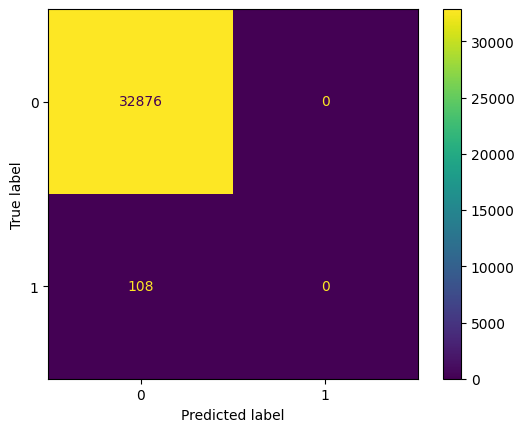

In [29]:
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)


ConfusionMatrixDisplay(confusion).plot()

In [32]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# Compute precision and recall values
precision2, recall2, _ = precision_recall_curve(y_test, y_pred)

# Calculate the area under the precision-recall curve (PRAUC)
prauc = auc(recall2, precision2)

print('PRAUC:', prauc)

ap = average_precision_score(y_test, y_pred)
print('average_precision_score', ap)

PRAUC: 0.05877397829272746
average_precision_score 0.061954921445279296


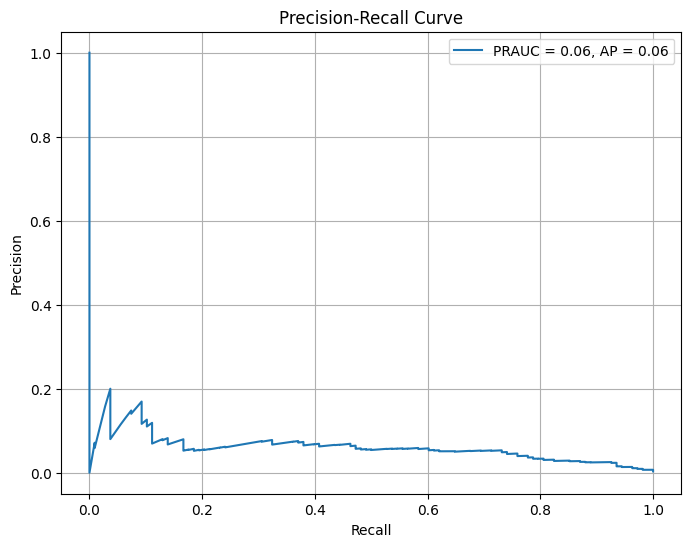

In [33]:
# Calculate the Average Precision (AP) to display in the plot
ap = average_precision_score(y_test, y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall2, precision2, label=f'PRAUC = {prauc:.2f}, AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()